In [6]:
import json
import os
import glob
import re
import matplotlib.pyplot as plt

In [7]:
for i in range(10):
    print(i)
    os.system("./build/src/tuk_numa_benchmark --benchmark_format=json > sequential_{}.json".format(i))

0
1
2
3
4
5
6
7
8
9


In [8]:
def add_benchmarks(merged_dict, f_dict):
    for benchmark in f_dict['benchmarks']:
        merged_dict[benchmark['name']].append(benchmark['real_time'])
    return merged_dict

In [20]:
json_files = glob.glob('*.json')
merged_dict = dict()
for json_file in json_files:
    f = open(json_file, "r").read()
    f_dict = json.loads(re.sub(r'0{5,}', '', f))
    if not bool(merged_dict):
    # Dict is empty
        for benchmark in f_dict['benchmarks']:
            merged_dict[benchmark['name']] = []
    merged_dict = add_benchmarks(merged_dict, f_dict) 

merged_dict_copy = merged_dict.copy()
for key in merged_dict_copy.keys():
    if '/0' in key:
        del merged_dict[key]
        
merged_dict

{'BM_ColumnScan_1M_Rows__LocalCols/1': [126,
  185,
  120,
  125,
  119,
  140,
  119,
  120,
  121,
  153],
 'BM_ColumnScan_1M_Rows__LocalCols/2': [315,
  314,
  308,
  465,
  299,
  334,
  299,
  346,
  303,
  316],
 'BM_ColumnScan_1M_Rows__LocalCols/4': [1030,
  728,
  729,
  740,
  731,
  979,
  754,
  860,
  830,
  757],
 'BM_ColumnScan_1M_Rows__LocalCols/8': [1679,
  1676,
  1497,
  1502,
  1506,
  1537,
  1522,
  1730,
  1518,
  1718],
 'BM_ColumnScan_1M_Rows__RemoteCols/1': [145,
  119,
  119,
  160,
  119,
  124,
  122,
  126,
  118,
  133],
 'BM_ColumnScan_1M_Rows__RemoteCols/2': [448,
  315,
  387,
  379,
  387,
  329,
  302,
  369,
  416,
  346],
 'BM_ColumnScan_1M_Rows__RemoteCols/4': [959,
  802,
  849,
  885,
  1068,
  793,
  754,
  870,
  1124,
  842],
 'BM_ColumnScan_1M_Rows__RemoteCols/8': [1764,
  1475,
  1502,
  1703,
  1599,
  1765,
  1499,
  1580,
  2051,
  1521]}

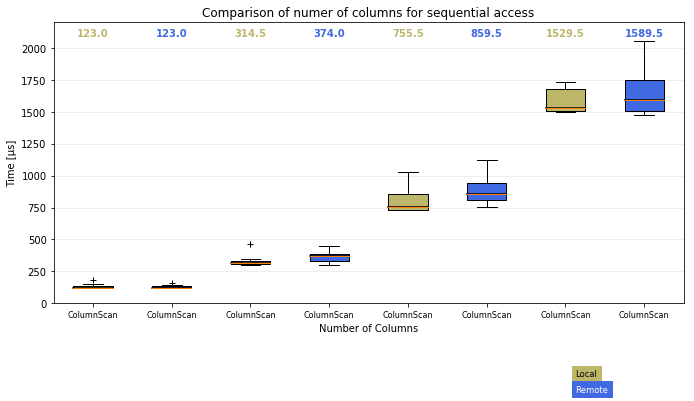

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
N = 500
numDists = 4
sortedKeys = ['BM_ColumnScan_1M_Rows__LocalCols/1', 'BM_ColumnScan_1M_Rows__RemoteCols/1', 'BM_ColumnScan_1M_Rows__LocalCols/2', 'BM_ColumnScan_1M_Rows__RemoteCols/2', 'BM_ColumnScan_1M_Rows__LocalCols/4', 'BM_ColumnScan_1M_Rows__RemoteCols/4', 'BM_ColumnScan_1M_Rows__LocalCols/8', 'BM_ColumnScan_1M_Rows__RemoteCols/8']

randomDists = sorted([x.replace('BM_ColumnScan_1GB_Sequential_', '') for x in sortedKeys])
randomDists = [label.split('_')[1].split('_')[0] for label in randomDists]
data = [merged_dict[k] for k in sortedKeys]

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of numer of columns for sequential access')
ax1.set_xlabel('Number of Columns')
ax1.set_ylabel('Time [μs]')

# Now fill the boxes with desired colors
boxColors = ['darkkhaki', 'royalblue']
numBoxes = numDists*2
medians = list(range(numBoxes))
for i in range(numBoxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    #plt.plot([np.average(med.get_xdata())], [np.average(data[i])], color='w', marker='*', markeredgecolor='k')


ax1.set_xlim(0.5, numBoxes + 0.5)
top = 2200
bottom = 0
ax1.set_ylim(bottom, top)
xtickNames = plt.setp(ax1, xticklabels=np.repeat(randomDists, 2))
plt.setp(xtickNames, fontsize=8)

pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='medium', weight=weights[k],
             color=boxColors[k])

plt.figtext(0.80, 0.08, 'Local', backgroundcolor=boxColors[0], color='black', weight='roman', size='small')
plt.figtext(0.80, 0.045, 'Remote', backgroundcolor=boxColors[1],
            color='white', weight='roman', size='small')
#plt.figtext(0.80, 0.015, '*', color='white', backgroundcolor='silver', weight='roman', size='small')
#plt.figtext(0.815, 0.013, ' Average Value', color='black', weight='roman', size='x-small')

plt.plot()
plt.savefig("sequential.svg", format="svg")
plt.show()